<a href="https://colab.research.google.com/github/mchivuku/csb659-project/blob/master/Homework4_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto-Encoder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Masters-DS/Deep\ Learning\ -\ E533/


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Masters-DS/Deep Learning - E533


In [10]:
%cd Homework4

/content/drive/My Drive/Masters-DS/Deep Learning - E533/Homework4


In [0]:
%%capture
!pip install tqdm six


!pip install bokeh
!pip install tensorboard
!pip install livelossplot

!pip install tensorboard

## Import Libraries

In [6]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim


import os
from torchvision.utils import save_image

## Plotting library

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
from livelossplot import PlotLosses


plt.style.use('ggplot')

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
print(torch.cuda.is_available())

is_cuda = torch.cuda.is_available()
device = torch.device ( "cuda:0" if torch.cuda.is_available () else "cpu" )

Torch 1.0.1.post2 CUDA 10.0.130
Device: cuda:0
True


## Helper Functions

In [0]:
## Show image
def imshow(img,title=None):
  """Imshow for Tensor."""
  img = img.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean # normalize
  img = np.clip(img, 0, 1) # clip image
  plt.figure(figsize=(16,4))
  plt.axis('off')
  plt.imshow(img)
  
  if title is not None:
    plt.title(title)         
  
def plot_grid(inputs):
  # Make a grid from batch 
  out = torchvision.utils.make_grid(inputs,10,10)
  imshow(out, title="")
  
  
  
  
def plot_loss(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  
def plot_accuracy(y, title):
  plt.figure()
  plt.plot(y)
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  

## TensorBoard - Utilities

In [0]:
import tensorflow as tf
import numpy as np
import scipy.misc 
from PIL import Image 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x

## Import tensor flow library
class TensorBoardLogger(object):
  
  """
  Initialize the summary writer
  """
  def __init__(self, log_dir):
    "create summary writer"
    self.writer = tf.summary.FileWriter(log_dir)
  
  """
  Add scalar
  """
  def scalar_summary(self, tag, value, step):
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
    self.writer.add_summary(summary,step)
    
  """
  Add images
  """
  def image_summary(self, tag, images, step):
    """Log a list of images."""

    img_summaries = []
    for i, img in enumerate(images):
        s = BytesIO()
        
        new_p = Image.fromarray(img)
        if new_p.mode != 'L':
          new_p = new_p.convert('L')
    
        new_p.save(s, format="png")

        # Create an Image object
        img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                   height=img.shape[0],
                                   width=img.shape[1])
        # Create a Summary value
        img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

    # Create and write Summary
    summary = tf.Summary(value=img_summaries)
    self.writer.add_summary(summary, step)
        
  def histo_summary(self, tag, values, step, bins=1000):
      """Log a histogram of the tensor of values."""

      # Create a histogram using numpy
      counts, bin_edges = np.histogram(values, bins=bins)

      # Fill the fields of the histogram proto
      hist = tf.HistogramProto()
      hist.min = float(np.min(values))
      hist.max = float(np.max(values))
      hist.num = int(np.prod(values.shape))
      hist.sum = float(np.sum(values))
      hist.sum_squares = float(np.sum(values**2))

      # Drop the start of the first bin
      bin_edges = bin_edges[1:]

      # Add bin edges and counts
      for edge in bin_edges:
          hist.bucket_limit.append(edge)
      for c in counts:
          hist.bucket.append(c)

      # Create and write Summary
      summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
      self.writer.add_summary(summary, step)
      self.writer.flush()
      
      
 

In [12]:
import os

def make_dirs(dirname):
  if not os.path.exists(dirname):
    os.makedirs(dirname)
    
    
#make_dirs("logs")
%ls

homework_4.pdf  logs/                           ngrok-stable-linux-amd64.zip.3
hw4_te7.pkl     ngrok                           ngrok-stable-linux-amd64.zip.4
hw4_tes.pkl     ngrok-stable-linux-amd64.zip    ngrok-stable-linux-amd64.zip.5
hw4_tr7.pkl     ngrok-stable-linux-amd64.zip.1  ngrok-stable-linux-amd64.zip.6
hw4_trs.pkl     ngrok-stable-linux-amd64.zip.2


In [13]:
## Logging
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    

--2019-04-05 00:11:15--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.21.103.149, 34.204.22.7, 52.73.9.93, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.21.103.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.7’

ngrok-stable-linux- 100%[===================>]  14.28M  40.0MB/s    in 0.4s    

2019-04-05 00:11:15 (40.0 MB/s) - ‘ngrok-stable-linux-amd64.zip.7’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://b92019df.ngrok.io


## Running Average

In [0]:
class RunningAverage ():
    """A simple class that maintains the running average of a quantity
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__( self ):
        self.steps = 0
        self.total = 0

    def update( self, val ):
        self.total += val
        self.steps += 1

    def __call__( self ):
        return self.total / float ( self.steps )

## DataLoader

In [19]:
import pickle

def load_pickle(file):
  with open(file, 'rb') as f:
    data = pickle.load(f)
  return data


train_data = load_pickle("hw4_tr7.pkl")
test_data = load_pickle("hw4_te7.pkl")

print(f"Train: {train.shape}, test:{test.shape}")




Train: (6265, 28, 28), test:(1028, 28, 28)


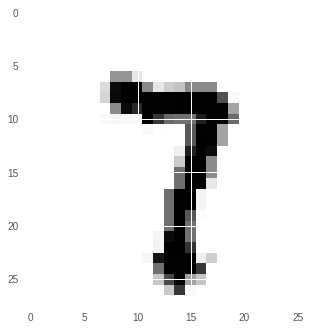

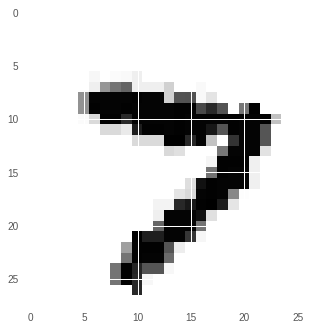

In [20]:
plt.imshow(np.array(train_data[2]))
plt.show()
plt.imshow(np.array(train_data[10]))
plt.show()

In [0]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, num_workers=2, batch_size=batch_size,
								shuffle=True, drop_last=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, num_workers=2, batch_size=batch_size,
								shuffle=True, drop_last=True, pin_memory=True)


In [0]:
sample = next(iter(train_loader))

## Network

In [22]:
print(f"Total number of train images: {train_data.shape[0]}, total number of test images: {test_data.shape[0]}, total number of train batches: {len(train_loader)}")

Total number of train images: 6265, total number of test images: 1028, total number of train batches: 48


In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

      
class ConvVAE(nn.Module):
    def __init__(self, nb_latents):
        super(ConvVAE, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1),
            nn.ReLU())
        
        self.fc1 = nn.Linear(1024, 256)
        
        self.fc_mean = nn.Linear(256, nb_latents)
        self.fc_std = nn.Linear(256, nb_latents)
        
        self.fc2 = nn.Linear(nb_latents, 256)
        self.fc3 = nn.Linear(256, 1024)
        
        
        
        self.fc4 = nn.Linear(1024,7*7*64)
        
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
    
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        x = (self.conv1(x))
        x =  (self.conv2(x))
        x =  (self.conv3(x))
        x =  (self.conv4(x))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc_mean(x), self.fc_std(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        x = self.relu(self.fc2(z))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.deconv1(x.view(-1, 64, 7, 7)))
        x = self.deconv2(x)
        return self.sigmoid(x)
        
    def forward(self, x):
        mu, logvar = self.encode(x.unsqueeze(1))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [24]:
model = ConvVAE(3)
if is_cuda:
  model = model.to(device)
  
print(model)

ConvVAE(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc_mean): Linear(in_features=256, out_features=3, bias=True)
  (fc_std): Linear(in_features=256, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=256, bias=True)
  (fc3): Linear(in_features=256

## Loss Function - KL divergence and Reconstruction Loss

In [0]:
### Loss Function

def loss_function(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction="sum")
  # https://arxiv.org/abs/1312.6114
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  
  return BCE + KLD


##Params

In [47]:
params = {
    "batch_size":128,
    "epochs" : 20,
    "log_interval":10,
    "nb_latents" : 3,
    "save_interval":10,
    
}

torch.manual_seed(5)

## Train Network

In [0]:
 

criterion = nn.CrossEntropyLoss()
logger = TensorBoardLogger("./logs") 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

"""
Traverse Latents
"""
def traverse_latents(model, datapoint, nb_latents, epoch, batch_idx, dirpath="logs",istrain=True):
  model.eval()
  
  if isinstance(model,ConvVAE):
    datapoint = datapoint.unsqueeze(0)
    datapoint = datapoint.unsqueeze(0).to(device)
    mu, _ = model.encode(datapoint)
  else:
    mu, _ = model.encode(datapoint.view(-1))
  
  recons = torch.zeros((7, nb_latents, 28, 28))
  
  ## Loop through 1 latent space
  ## Keep other two constant
  val1 = torch.randn(1)[0] 
  val2 = torch.randn(1)[0]
  
  for zi in range(nb_latents):
    muc = mu.squeeze().clone()
    
    for i, val in enumerate(np.linspace(-3, 3, 7)):
      if istrain:
        muc[zi] = val
      else:
        if zi == 1:
          muc[zi] = val1
        elif zi == 2:
          muc[zi] = val2
        else:
          muc[zi] = val
          
      recon = model.decode(muc).cpu()
      recons[i, zi] = recon.view(28, 28)
  if not istrain:
    print(muc[zi])
  
  name = "train_reconstruction_" if istrain else "test_reconstruction_"
  filename = os.path.join(dirpath,  name + str(epoch) + '_' + str(batch_idx) + '.png')
  save_image(recons.view(-1, 1, 28, 28), filename, nrow=nb_latents, pad_value=1)
  

def train(epoch):
  model.train()
  
  
  loss_log = RunningAverage()
  
  ## Test reconstruction test
  testpoint = torch.Tensor(train_loader.dataset[0])
  
  for batch_idx, (data ) in enumerate(train_loader):
    data = data.to(device)
    
    optimizer.zero_grad()
    batch_size = data.size(0)
    
    recon_batch, mu, logvar = model(data)
    
    
    ## Loss of VAE
    loss = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
    loss.backward()
    
    loss_log.update(loss.item() / len(data))
    
    # 1. Log scalar values (scalar summary)
    info = { 'loss': loss }

    for tag, value in info.items():
      logger.scalar_summary(tag, value, epoch+1)

    # 2. Log values and gradients of the parameters (histogram summary)
    for tag, value in model.named_parameters():
      tag = tag.replace('.', '/')
      logger.histo_summary(tag, value.data.cpu().numpy(), epoch+1)
      logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), epoch+1)

    
    optimizer.step()
    
    
    ## Accuracy 
    if batch_idx % params.get("log_interval") == 0:
      
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, \t '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
      
    if not batch_idx % params.get("save_interval"):
      traverse_latents(model, testpoint, params.get("nb_latents"), epoch, batch_idx)
    
      
  print("==> Epoch {}, average loss: {:.4f}".format(epoch, loss_log()))
  return loss_log()



## Test

In [0]:
"""
Test
"""
def test(epoch):
    model.eval()
    test_loss = RunningAverage()
    
    ## Test reconstruction test
    testpoint = torch.Tensor(test_loader.dataset[0])
  
    with torch.no_grad():
        for i, (data) in enumerate(test_loader):
            data = data.to(device)
             
            batch_size = data.size(0)
            recon_batch, mu, logvar = model(data)
            ## Loss of VAE
            loss = loss_function(recon_batch.squeeze().view(-1,28*28), data, mu, logvar)
            test_loss.update(loss.item() / len(data))
            # 1. Log scalar values (scalar summary)
            info = { 'test_loss': loss }

            for tag, value in info.items():
                logger.scalar_summary(tag, value, epoch+1)
            if i == 0:
                n = min(data.size(0), 8)
                p = recon_batch.squeeze().view(-1,28,28)[:n]
                comparison = torch.cat([data[:n].view(-1,28,28),p])
               
                traverse_latents(model, comparison[0], params.get("nb_latents"), epoch, i, istrain=False)

   
    return test_loss()

In [0]:
train_loss = []
test_loss = []

for epoch in range(1, params.get("epochs") + 1):
        trainloss = train(epoch)
        train_loss.append(trainloss)
    
        ## test 
        tes_loss = test(epoch)
        test_loss.append(tes_loss)
        
        



Train Epoch: 1 [0/6265 (0%)]	Loss: 182.764618, 	 
Train Epoch: 1 [1280/6265 (21%)]	Loss: 148.340897, 	 
Train Epoch: 1 [2560/6265 (42%)]	Loss: 142.314499, 	 
Train Epoch: 1 [3840/6265 (62%)]	Loss: 145.873688, 	 
Train Epoch: 1 [5120/6265 (83%)]	Loss: 140.453262, 	 
==> Epoch 1, average loss: 143.3890
tensor(0.9875, device='cuda:0')
Train Epoch: 2 [0/6265 (0%)]	Loss: 187.261780, 	 
Train Epoch: 2 [1280/6265 (21%)]	Loss: 137.460922, 	 
Train Epoch: 2 [2560/6265 (42%)]	Loss: 133.626190, 	 


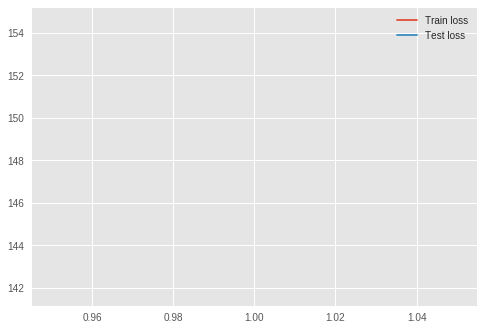

In [44]:
plt.plot(range(1, params.get("epochs") + 1),train_loss)
plt.plot(range(1, params.get("epochs") + 1),test_loss)
plt.legend(["Train loss","Test loss"])
plt.show()

One way to prove that you found the latent dimension of interest is to show - the digits generated by the decoder

More specifically, you may want to "generate" new 7s by feeding a few randomly generated code vectors, that are random samples from K normal distributions that are your VAAE learned. 


Fix k-1 dimensions with same value over codes, while varying only one of them.




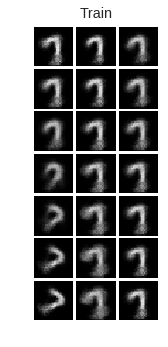

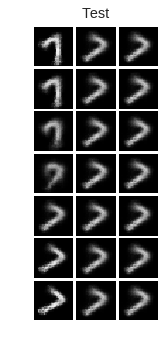

In [46]:
import cv2
img = cv2.imread("./logs/train_reconstruction_1_0.png")
plt.imshow(np.array(img))
plt.axis("off")
plt.title("Train")
plt.show()

img = cv2.imread("./logs/test_reconstruction_1_0.png")
plt.imshow(np.array(img))
plt.axis("off")
plt.title("Test")
plt.show()

In [33]:
import torch
torch.randn(1)[0].to(device)

tensor(0.2509, device='cuda:0')